<a href="https://colab.research.google.com/github.com/iam-dante/vision-transformer/blob/main/vision-transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Vision Transformer Paper (ViT)

"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" [paper](https://arxiv.org/abs/2010.11929), introduces a 
groundbreaking approach to image classification by leveraging the power of transformer architectures. Authored by Alexey Dosovitskiy et al., 
the paper challenges the conventional convolutional neural network (CNN) paradigm that has long dominated the field of computer vision. 
ViT extends the success of transformers from natural language processing to image analysis, demonstrating remarkable performance on various 
image recognition tasks. This introduction will provide an overview of the key concepts and contributions of the Vision Transformer paper, 
setting the stage for a deeper exploration of its innovative methodology and experimental results.
This implementation will focus on the base architecure of ViT paper but will enable adjustment on the hyperparameters to the architecture.

1. Data Preparations
2. Architecture Implementation
3. Training
4. Testing
5. Visulizing Results








In [1]:
# Import Libraries
import torch
from torch import nn

# Import Torch Vision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchinfo import summary

# Visulalization
import matplotlib.pyplot as plt
from pathlib import Path


from modular_functions import data_setup, engine

# Check the torch, vision version
print(torch.__version__)
print(torchvision.__version__)


2.1.0
0.16.0


In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

## 1. Data Preparation

In the Vision Transformer (ViT) paper, the authors propose a novel approach to handling image data by transforming it into a sequence of fixed-size patches before feeding it into a transformer model. This is a departure from traditional convolutional neural networks (CNNs), where the input images are processed using convolutional layers. This is the first step that should be considered before implementing the architecture.

The specific image transformation steps performed before training the Vision Transformer include:

1. **Patch Extraction:** The input image is divided into non-overlapping patches. Each patch is then treated as a token, forming a sequence of image patches.

2. **Linear Projection:** Each patch is linearly projected into a high-dimensional space, typically referred to as the embedding space. This projection allows the model to capture meaningful representations of image content.

3. **Positional Encoding:** To provide the transformer model with information about the spatial relationships between the patches, positional encodings are added. This helps the model understand the sequential order of the patches in the input sequence.

By converting the image into a sequence of patches and using a transformer architecture, the Vision Transformer effectively captures long-range dependencies and relationships within the image. This innovative approach has shown impressive results in image classification tasks, challenging the conventional wisdom that CNNs are the sole architecture suitable for computer vision applications.


<image src="./images/info-architecture.png" alt="" height="500" wight="500"/>

In [3]:
# Directory of the dataset
image_path = Path("dataset/pizza_steak_sushi")

# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [4]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [5]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transforms=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader 
print(f"The classes are {class_names}")

The classes are ['pizza', 'steak', 'sushi']


In [6]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

In [7]:
# Variables from the paper.

height = 224 # H ("The training resolution is 224")
width = 224 # W
color_channels = 3 # Are we are dealing with color images
patch_size = 16 # Patch size by with and height

# Calculate N (number of patches)
num_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {num_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [8]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (num_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


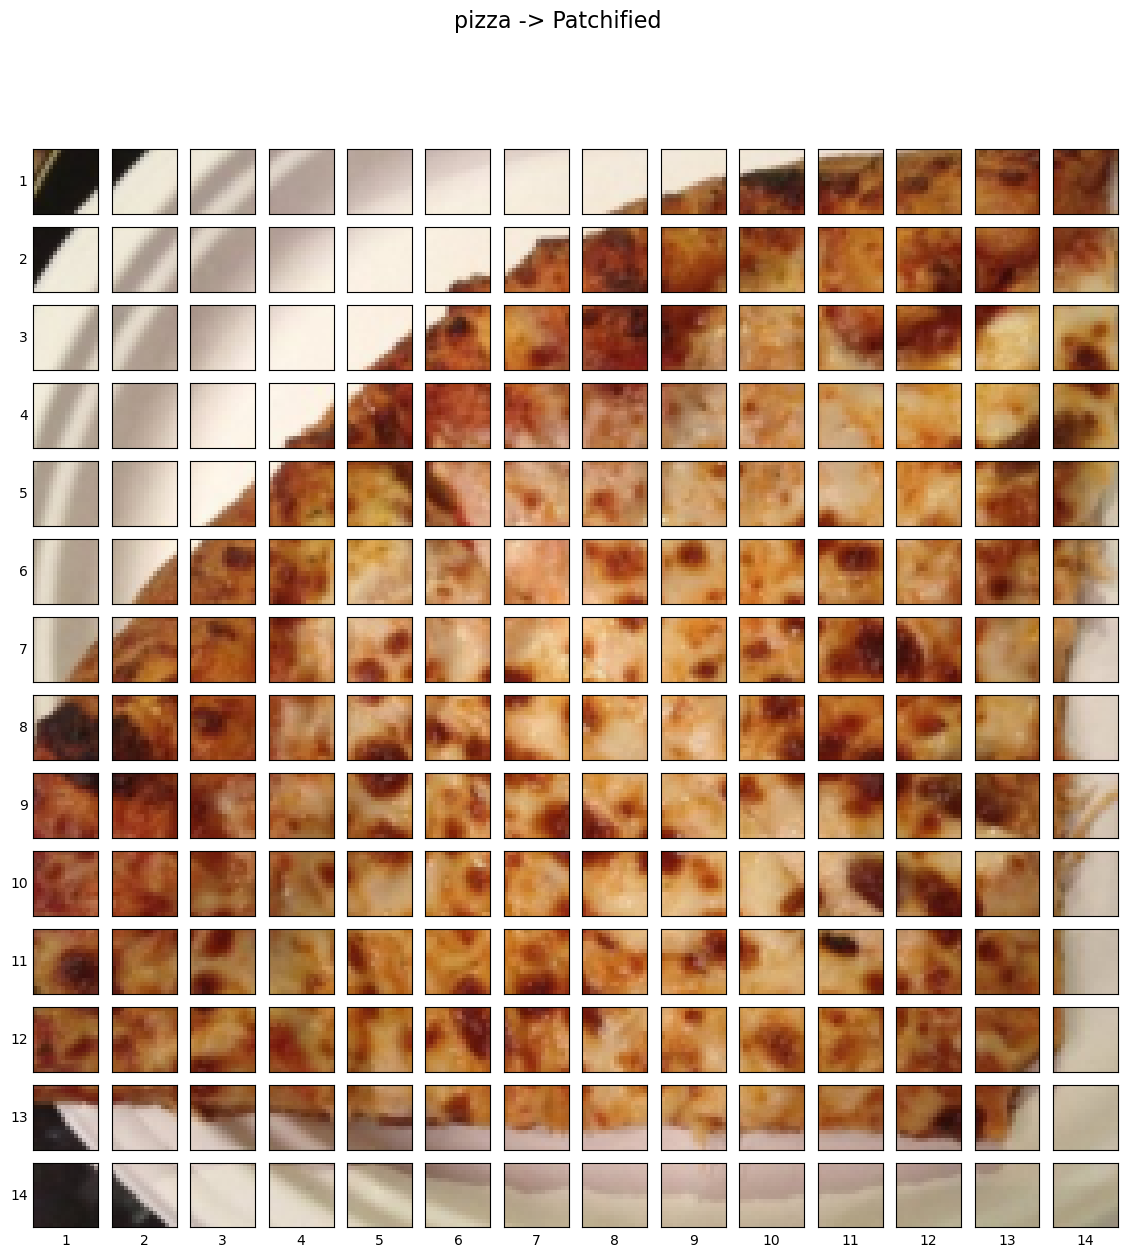

In [9]:
#Visualizing the patch making on an image
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)


assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [10]:
# Implementation of PatchEmbedding
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768,
                 embedding_dropout:float=0.1):
        
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
        # Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
        
        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution% patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Get batch size
        batch_size = x.shape[0]

        # Perform the forward pass
        x_patched = self.patcher(x)

        # Flattern the input
        x_flattened = self.flatten(x_patched)

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x_flattened.permute(0, 2, 1)), dim=1)

        # Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        return x

In [11]:
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768,
                          )

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 197, 768])


## 2. Architecture Implementation

*This part will be divided into two main:*

2.1 **Multi-self attention block** 
2.2 **Mutli Layer Perceptron block** 




<image src="./images/info-msa-mlp.png" alt="" height="400" wight="400"/>

2.1 **Multi-self attention block** 

In the Vision Transformer (ViT) paper, the concept of a "Multi-head Self Attention Block" is a fundamental building block within the transformer architecture used for image recognition tasks. The ViT model employs multiple such attention blocks to capture rich contextual information from input sequences, in this case, sequences of image patches. Let's break down the key components of the Multi-head Self Attention Block based on the ViT paper:

1. **Self Attention Mechanism:**
   - The core of the attention block is the self-attention mechanism, which allows the model to weigh different elements of the input sequence differently based on their relevance to each other.
   - Self attention calculates attention scores for each element in the sequence relative to every other element, enabling the model to focus on different parts of the input sequence during processing.

2. **Multi-head Attention:**
   - The ViT paper introduces the concept of using multiple attention heads within a single attention block. Each attention head learns a different set of attention weights, capturing diverse relationships in the input.
   - The outputs from these multiple attention heads are concatenated and linearly projected to create a final set of representations.

3. **Parameterized Linear Projections:**
   - The attention block includes linear projections to transform the input sequence into query, key, and value representations. These projections are learned during the training process.
   - Multiple sets of projections are employed for each attention head, allowing the model to capture various aspects of the input information.

4. **Normalization and Feedforward Layer:**
   - Normalization layers, such as layer normalization, are applied to the concatenated outputs of the attention heads.
   - A feedforward neural network is then applied to further process the information, introducing non-linearity and capturing complex patterns.




2.2 **Multi Layer Perceptron**

In the Vision Transformer (ViT) paper, the "MLP (Multi-Layer Perceptron) Block" is another crucial component of the transformer architecture. The MLP Block is employed after the multi-head self-attention mechanism in each transformer layer, contributing to the model's ability to capture and process hierarchical features from the input sequence of image patches. Let's delve into the key characteristics of the MLP Block based on the ViT paper:

1. **Position-wise Feedforward Networks:**
   - The MLP Block consists of one or more position-wise feedforward networks. These networks operate independently on each position in the sequence, allowing the model to capture local patterns and non-linear relationships within the data.
   - The position-wise feedforward networks include fully connected layers with a non-linear activation function (commonly ReLU) in between but in this architure according to the paper the MLP contains two layers with a GELU non-linearity (section 3.1).

2. **Parameterized Linear Projections:**
   - Similar to the multi-head self-attention block, the MLP Block includes linear projections to transform the input features. These projections are learned during the training process.
   - The linear projections are typically followed by activation functions, introducing non-linearity to the model.

3. **Normalization:**
   - Normalization layers, such as layer normalization, are applied to the output of the MLP Block. This helps stabilize the training process and improve the model's generalization.

4. **Skip Connection and Residual Connection:**
   - To facilitate the flow of information through the model, skip connections (also known as residual connections) are commonly employed. These connections allow the output of the MLP Block to be added to the input, aiding in the gradient flow during training.


   **Residual Connection** -  connects the output of one earlier convolutional layer to the input of another future convolutional layer several layers later


In summary, the Multi-head Self Attention Block in the ViT paper incorporates multiple attention heads to enable the model to attend to different aspects of the input image patches simultaneously. This parallel processing enhances the model's ability to capture diverse and hierarchical features in the data, contributing to its success in image recognition tasks.
The role of the MLP Block is to capture and process local features within the input sequence. While the multi-head self-attention mechanism focuses on capturing global contextual information, the MLP Block helps the model capture and leverage detailed local patterns. The combination of these components contributes to the success of the Vision Transformer in image recognition tasks.

## Multi Self Attention Block

In [12]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """ 

        Create a multi-head self attention block (MSA - Block)

    """
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:int=0):
        super().__init__()
        
        # Create a layer norm (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create a multihead attention (MSA) layer
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                         num_heads=num_heads,
                                                         dropout=attn_dropout,
                                                         batch_first=True) # is batch size first ? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimesion)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attention(query=x,
                                               key=x,
                                               value=x,
                                               need_weights=False)
        
        # attn_output = attn_output + x
        return attn_output

In [13]:
# Testing the shape of an image after through the MSA-Block is equal to the patchfied image shape.
# Create an instance of MSABlock
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_embedded_image)
print(f"Input shape of MSA block: {patch_embedded_image.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## Multi Layer Perceptron

In [14]:
# 1. Create a class that inherits from nn.Module
class MultiLayerPerceptron(nn.Module):
    """
    Creates a layer normalized multilayer perceptron block ("MLP block" for short).

    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [15]:
# Testing the shape of an image after through the MLP-Block is equal to the MSA-Block image shape .
# Create an instance of MLPBlock
mlp_block =  MultiLayerPerceptron(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## Transformer Encoder Block 
*Joining the MSA-Block and MLP Block*

In [16]:
# Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """
    Creates a Transformer Encoder block.
    """
    # Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # Create MLP block (equation 3)
        self.mlp_block =  MultiLayerPerceptron(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # Create a forward() method
    def forward(self, x):

        # Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

## The whole Vision Transformer (ViT)

In [17]:
class VisionTransformer(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # # 4. Calculate number of patches (height * width/patch^2)
        # self.num_patches = (img_size * img_size) // patch_size**2

        # # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        # self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
        #                                     requires_grad=True)

        # # 6. Create learnable position embedding
        # self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
        #                                        requires_grad=True)

        # # 7. Create embedding dropout value
        # self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # # 12. Get batch size
        # batch_size = x.shape[0]

        # # 13. Create class token embedding and expand it to match the batch size (equation 1)
        # class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # # 15. Concat class embedding and patch embedding (equation 1)
        # x = torch.cat((class_token, x), dim=1)

        # # 16. Add position embedding to patch embedding (equation 1)
        # x = self.position_embedding + x

        # # 17. Run embedding dropout (Appendix B.1)
        # x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [18]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = VisionTransformer(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.0333, -0.2131, -0.0092]], grad_fn=<AddmmBackward0>)

In [19]:
# Print a summary of our custom ViT model using torchinfo 
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                             [32, 3, 224, 224]    [32, 3]              --                   True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
│    └─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           

In [29]:
from modular_functions import engine, utils

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
utils.set_seeds(seed=42, set_device=device)

# Train the model and save the training results to a dictionary
results = engine.train(model=vit.to(device),
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

TypeError: set_seeds() got an unexpected keyword argument 'set_device'

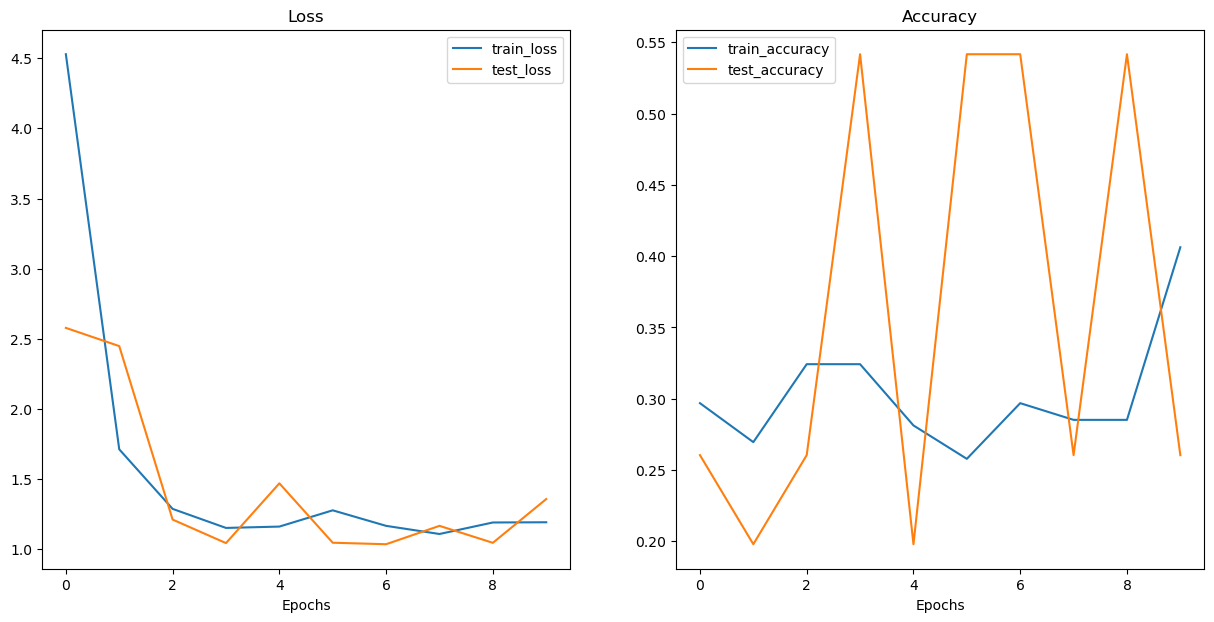

In [48]:
# Visualizing the results from the traiing

from modular_functions.utils import plot_loss_curves

plot_loss_curves(results)

In [49]:
from modular_functions.utils import save_model

save_model(model=vit,
           target_dir="models",
           model_name="vit.pth")

[INFO] Saving model to: models/vit.pth


## Transfoer Learning on Vision Transformer Architecture.
The results of only using the model where bad as test accuracy was 26% this is because the we had few number of image dataset. Transfer learning has proven to be a powerful technique in enhancing the performance of neural network models, including the Vision Transformer (ViT). By leveraging pre-trained models on large datasets, transfer learning allows the ViT to benefit from knowledge gained in solving one task and apply it to a related task, even with limited labeled data. So inorder to improve the test accuracy of the model we will use `ViT_B_16_Weights` as we are dealing with 16 * 16 patch size.


In [50]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [51]:
# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [52]:
# Visualize the Pretrained Vision Architecture
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [53]:
# Prepare the data according to the transformation done on the pretrained weights
vit_transform = pretrained_vit_weights.transforms()
vit_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [54]:
# Create a dataloader with the new transform
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transforms=vit_transform,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [55]:
# Create optimizer and loss function according to the paper
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = engine.train(model=pretrained_vit.to(device),
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8099 | train_acc: 0.7109 | test_loss: 0.5026 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.3756 | train_acc: 0.9336 | test_loss: 0.3265 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.2154 | train_acc: 0.9609 | test_loss: 0.2357 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.1575 | train_acc: 0.9570 | test_loss: 0.2186 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.1379 | train_acc: 0.9727 | test_loss: 0.2139 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.1262 | train_acc: 0.9766 | test_loss: 0.2093 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.1565 | train_acc: 0.9766 | test_loss: 0.2034 | test_acc: 0.8873
Epoch: 8 | train_loss: 0.0901 | train_acc: 0.9805 | test_loss: 0.2357 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.0904 | train_acc: 0.9805 | test_loss: 0.2530 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.0759 | train_acc: 0.9805 | test_loss: 0.2489 | test_acc: 0.8769


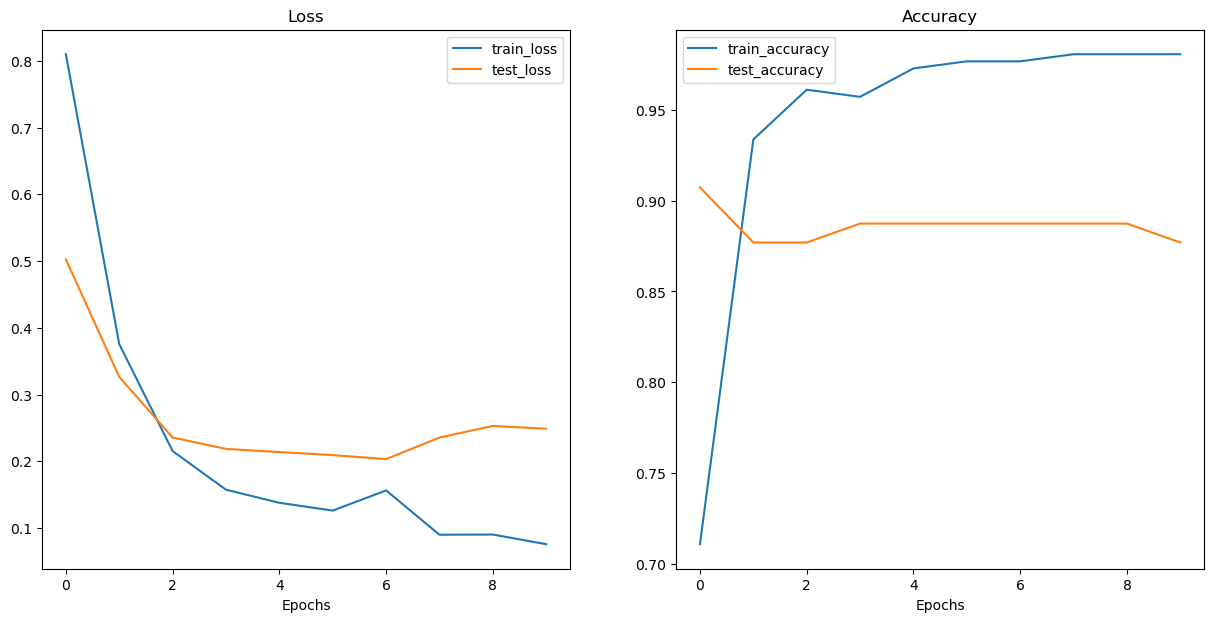

In [56]:
# Plot the loss curves
from modular_functions.utils import plot_loss_curves

plot_loss_curves(pretrained_vit_results)